# Préliminaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from random import gauss
from scipy import optimize
import scipy.special as sc

# I- Schéma hybride

In [2]:
################## Fonction noyau ##########################################
def kernel_g(x, a):
    return x**a

################## b_k optimal #############################################
def b_opti(k, a):
    return pow((pow(k,a+1)-pow(k-1,a+1))/(a+1),1./a)

################## Matrice de covariance du vecteur (Z1,Z2) ################
def cov(alpha, n):
    cov = np.array([[0.,0.],[0.,0.]])
    cov[0,0] = 1./n
    cov[0,1] = 1./((alpha+1) * pow(n,alpha+1))
    cov[1,1] = 1./((2.*alpha+1) * pow(n,2.*alpha+1))
    cov[1,0] = cov[0,1]
    return cov

################## Fonction payoff d'un call européen ######################
def call_payoff(S,K):
    return np.maximum(S-K,0.)

################## Formule de Black et Scholes #############################
def bs_call(S, K, V):
    d1 = np.log(S/K) / np.sqrt(V) + 0.5 * np.sqrt(V)
    d2 = d1 - np.sqrt(V)
    P = S * norm.cdf(d1) - K *norm.cdf(d2)
    return P



In [5]:
def Hybrid(N=100,M=10000,T= 1,rho=-0.9,alpha=-0.43, zeta=0.235**2,eta=1.9, S0=1.):
  

    TT=np.linspace(0, T, N*T+1)[np.newaxis,:] 
    
    ############################################################################
    ############## Début simulation du processus de Volterra ###################
    ############################################################################
    
    mean= np.array([0.,0.])
    Sigma=cov(alpha,N)
    
    # On commence par simuler un vecteur aléatoire (Z1, Z2) centré et de matrice
    # de variance covariance Sigma défini ci-dessus
    def dW():
        return np.random.multivariate_normal(mean, Sigma, (M,N*T)) 

    # Ici nous simulons la partie intégrale du schéma à l'aide de Z2
    Volt_1 = np.zeros((M, 1 + N*T)) # integrale stocastique 
    dW_= dW()
    dW1 = dW_[:,:,1] 

    for i in np.arange(1, 1 + N*T, 1):
            Volt_1[:,i] = dW1[:,i-1] 

    dW0 = dW_[:,:,0] 
    dW0.shape

    # Ensuite on simule la partie somme de Riemann en faisant une convolution 
    # avec Z1
    G_bk = np.zeros(1 + N*T)
    for k in np.arange(2, 1 + N*T, 1):
        G_bk[k] = kernel_g(b_opti(k, alpha)/N, alpha)

    Volt_2 = np.zeros((M, 1 + N*T))
    Convolve_=np.zeros((M, 2*N*T)) 

    for k in range(M):
        Convolve_[k,:]=np.convolve(G_bk,dW0[k,:])
    
    Volt_2 = Convolve_[:,:1 + N*T] #on en garde que pour i=0,...,N*T 

    # Enfin on somme Volt_1 et Volt_2, multiplie le tout par np.sqrt(2*alpha + 1) et nous 
    # obtenons une simulation du processus de Volterra
    Volt = np.sqrt(2. * alpha + 1) * (Volt_1 + Volt_2)

    ###########################################################################
    ############## Fin simulation du processus de Volterra ####################
    ########################################################################### 
    
    def dW_ortho():
        return np.random.randn(M, N*T) * np.sqrt(1./N)

    def dB(dW_, dW2, rho):
        dB_ = rho * dW_ + np.sqrt(1 - rho**2) * dW2
        return dB_
    
    dB_=dB(dW0,dW_ortho(),rho)

    ################## processus de variance ##################################   
    def V(Y, alpha_, zeta, eta,T):
        V_ = zeta * np.exp(eta * Y - 0.5 * pow(eta,2) * pow(T,2 * alpha_ + 1))
        return V_

    V_=V(Volt, alpha, zeta, eta, TT)


    ################## processus de prix ######################################
    def S(V,dB,S00=S0):
        S_= np.sqrt(V[:,:-1])*dB - 0.5*V[:,:-1]*1./N
        inte = np.cumsum(S_, axis = 1)
        S = np.zeros((M,N*T+1))
        S[:,0] = S00
        S[:,1:] = S00 * np.exp(inte)
        return S

    S_= S(V_,dB_)

    ################## Prix du call eruropéen par Monte Carlo #################
    k = np.arange(-0.5, 0.51,(0.51+0.5)/(M*T))
    K = np.exp(k)[np.newaxis,:]
    Call_payoffs_ = call_payoff(S_[:,-1][:,np.newaxis],K)   
    Call_prices_ = np.mean(Call_payoffs_, axis=0)[:,np.newaxis]

    ################## Volatilité implicite ################################### 
    def bsinv(P, S, K, T):
    
        P = np.maximum(P, np.maximum((S - K), 0.))
    
        def f(sigma):
            return bs_call(S, K, pow(sigma,2)*T) - P

        #s = optimize.newton(f,x0=0.25,tol=10**(-6))
        s = optimize.brentq(f, pow(10,-9),pow(10,9))
        return s

    vec_bsinv = np.vectorize(bsinv)
    vol_implied = vec_bsinv(Call_prices_, S0, K.T,T)
    

    ################## plots ##################################################

    plt.plot(TT[0,:],Volt[1, :],"r")
    plt.title(r'$\alpha=-0.43$')
    plt.xlabel("time t")
    plt.ylabel("Volterra process")
    plt.grid(True)
    plt.show()

    plt.plot(TT[0,:],V_[1, :],"r")
    plt.title(r'$\alpha=-0.43, \rho=0$')
    plt.xlabel("time t")
    plt.ylabel("Variance process")
    plt.grid(True)
    plt.show()

    for i in range(30):
      plt.plot(TT[0,:], S_[i,])
      
    plt.title(r'$\alpha=-0.43$')
    plt.xlabel("time t")
    plt.ylabel("30 simulations du processus de prix")
    plt.grid(True)
    plt.show()

    plt.plot(k,Call_prices_,"r")
    plt.title("Call option Price")
    plt.xlabel("log-strike k")
    plt.ylabel("Option price")
    plt.grid(True)
    plt.show()

    plt.plot(k,vol_implied,"r")
    plt.title( r' $\alpha=-0.43,\rho=-0.9$')
    plt.xlabel("log-strike k")
    plt.ylabel("implied volatility")
    plt.grid(True)
    plt.show()
    
    return Call_prices_
    #return Volt,V_,S_,Call_prices_2,vol_implied

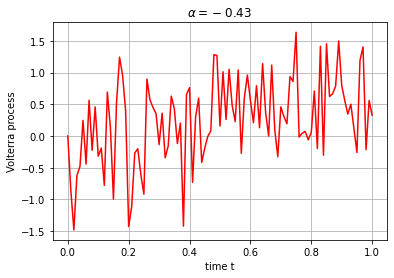

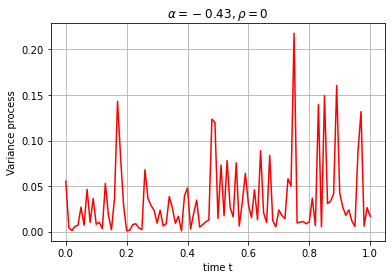

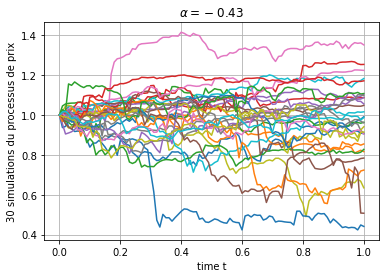

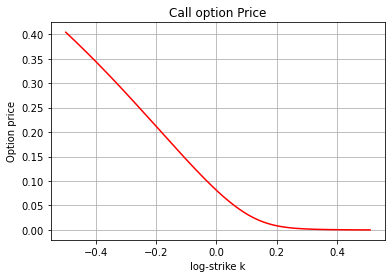

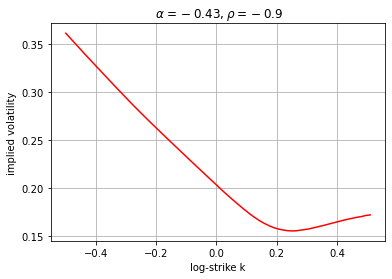

In [6]:
rrrrrr = Hybrid()

In [40]:
k = np.arange(-0.5, 0.51,(0.51+0.5)/(10000))
np.where(k >=0)

(array([4951, 4952, 4953, ..., 9997, 9998, 9999]),)

[0.08095855]


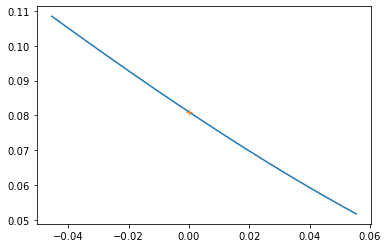

In [42]:
print(rrrrrr[4951])
plt.plot(k[4500:5500],rrrrrr[4500:5500])
plt.plot(rrrrrr[4951], marker = '+')
plt.show()

# II- Méthode de Cholesky

In [8]:

########################## Covariance du processus de Volterra #################################
def Voltera_cov(u,v,alpha):
    if (u==v):
        return u**(2*alpha+1)
    return pow(min(v,u),2.*alpha+1)*((2.*alpha+1)/(alpha+1))*pow(min(u,v)/max(u,v),-alpha)*sc.hyp2f1(1, -alpha, 2+alpha, min(u,v)/max(u,v))

########################## Covariance du mouvement brownien #####################################
def Brownian_cov(u,v):
    return min(u,v)

########################## Covariance entre les deux ############################################
def Brownian_Voltera_cov(u,v, alpha, rho):
    return rho*(np.sqrt(2.*alpha+1)/(alpha +1))*(pow(v,alpha+1)-pow((v-(min(v,u))),alpha+1))

########################## Matrice de covariance pour tout t,s ###################################
def Chol_cov(i,j, alpha, rho):
    return np.array([[Voltera_cov(i,j, alpha),Brownian_Voltera_cov(i,j, alpha, rho)],[Brownian_Voltera_cov(j,i, alpha, rho), Brownian_cov(i,j)]])

########################## Fonction pour appliquer Cholesky ###################################
def cholesky_(X,covmat):
    L = np.linalg.cholesky(covmat)
    matrix_chol= (L)@X
    return (matrix_chol)

In [9]:
def Cholesky(n=312,T= 1,rho=-0.9,alpha=-0.43,zeta=0.235**2,eta=1.9,S0=1.):

    ########################## Matrice de covariance taille=(n,n,2,2) ############################
    M=np.zeros((n,n,2,2))
    for i in range(n):
        for j in range(i,n):
            s=(i+1)/(n*T)
            t=(j+1)/(n*T)
            M[i,j]=Chol_cov(s,t, alpha, rho)
            M[j,i]=M[i,j]

    ########################## Reshape taille=(2n,2n) ############################################
    M=M.swapaxes(2,1).reshape(M.shape[0] * M.shape[2],-1)

    ########################## Application de Cholesky ############################################
    X=np.random.randn(2*n,1)
    L=cholesky_(X,M)
    A=np.zeros(n)
    B=np.zeros(n)
    for i in range(n):
        A[i]=L[2*i]
        B[i]=L[2*i+1]

    ########################## Valeur initiale des processus de 0 ##################################
    A=np.insert(A,0,0)
    B=np.insert(B,0,0)
    
    ########################## représentation des trajectoires #####################################
    x = np.linspace(0, T,T*n+1)
    plt.plot(x, A, label="Volterra process")
    plt.plot(x, B, label="Brownien process")
    plt.title("Brownian and Volterra processes")
    plt.grid(True)
    plt.legend()
    plt.show()

    ########################## Construction des incréments #########################################
    Inc=np.zeros(n)
    for i in range(1,n):
        Inc[i]=B[i]-B[i-1]

    ########################## Processus de variance ###############################################
    def V_cholesky(Y, alpha_, zeta, eta,T):
        V_ = zeta * np.exp(eta * Y - 0.5 * pow(eta,2) * pow(T,2 * alpha_ + 1))
        return V_

    V_chol=V_cholesky(A, alpha, zeta, eta, T)

    plt.plot(x,V_chol,"r")
    plt.title("Variance process")
    plt.xlabel("time t")
    plt.ylabel("variance process")
    plt.grid(True)
    plt.show()

    ########################## Processus de prix ###################################################
    def S_cholesky_(V,dB,n,S00=S0):
        S_=np.sqrt(V)*dB - 0.5*V*1./n
        integral = np.cumsum(S_,axis=0) 
        S = np.zeros((n*T+1))
        S[0] = S00
        S[1:] = S00 * np.exp(integral)
        return S

    S_cholesky=S_cholesky_(V_chol[:-1],Inc,n)

    plt.plot(x,S_cholesky,"r")
    plt.title("Price process")
    plt.xlabel("time t")
    plt.ylabel("Price process")
    plt.grid(True)
    plt.show()
    


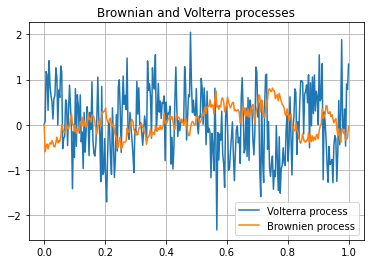

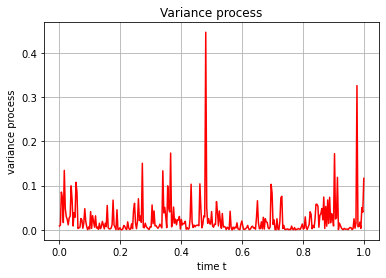

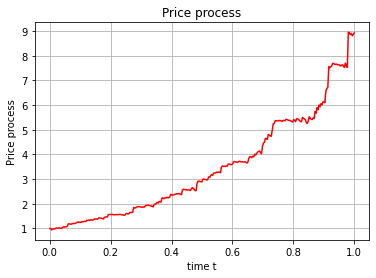

In [10]:
Cholesky()